In [40]:
##
# import necessary libraries and load data
##
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

try:
    data = pd.read_csv("../data/processed/ethiopia_fi_enriched.csv")
    impact = pd.read_csv("../data/processed/impact_links_enriched.csv")
    print("Data files loaded successfully.")
except FileNotFoundError:
    print("Data files not found. Please ensure the data is available in the specified paths.")

Data files loaded successfully.


In [41]:
assert "parent_id" in impact.columns
assert "record_id" in events.columns

events = data[data['record_type']=='event'].sort_values('observation_date')
data["observation_date"] = pd.to_datetime(data["observation_date"])
events = data[data["record_type"] == "event"]
observations = data[data["record_type"] == "observation"]

impact_full = impact.merge(
    events,
    left_on="parent_id",
    right_on="record_id",
    how="left",
    suffixes=("_impact", "_event")
)

In [42]:
##
# Build the Event-Indicator Matrix
##

# --- Fix tuple column issue (safe to run even if not needed)
impact_full.columns = [c if not isinstance(c, tuple) else c[0] for c in impact_full.columns]

# --- Define columns explicitly
event_col = "indicator_event"
rel_col = "related_indicator_impact"
impact_col = "impact_magnitude_impact"

# --- Convert impact magnitude to numeric
impact_full[impact_col] = pd.to_numeric(impact_full[impact_col], errors="coerce")

# --- Quick sanity check
print(impact_full[[event_col, rel_col, impact_col]].head())

# --- Build matrix
matrix = impact_full.pivot_table(
    index=event_col,
    columns=rel_col,
    values=impact_col,
    aggfunc="mean"
).fillna(0)

print(matrix)

# --- Save
try:
    matrix.to_csv("../data/processed/event_indicator_matrix.csv")
    print("Event-indicator matrix saved successfully.")
except Exception as e:
    print("Could not save the event-indicator matrix:", e)

                        indicator_event related_indicator_impact  \
0                       Telebirr Launch            ACC_OWNERSHIP   
1                       Telebirr Launch       USG_TELEBIRR_USERS   
2                       Telebirr Launch            USG_P2P_COUNT   
3  Safaricom Ethiopia Commercial Launch               ACC_4G_COV   
4  Safaricom Ethiopia Commercial Launch          AFF_DATA_INCOME   

   impact_magnitude_impact  
0                      NaN  
1                      NaN  
2                      NaN  
3                      NaN  
4                      NaN  
Empty DataFrame
Columns: []
Index: []
Event-indicator matrix saved successfully.


In [43]:
##
# Model How Events Affect Time Series
##

def apply_event_impact(series, events_df, indicator):
    result = series.copy()

    for _, row in events_df.iterrows():

        # --- Only apply to the right indicator
        if row["related_indicator_impact"] != indicator:
            continue

        # --- Event date with lag
        start = pd.to_datetime(row["observation_date_event"]) + pd.DateOffset(
            months=int(row["lag_months_impact"]) if pd.notnull(row["lag_months_impact"]) else 0
        )

        mask = result.index >= start

        # --- Direction
        direction = 1 if row["impact_direction_impact"] == "positive" else -1

        # --- Magnitude
        effect = row["impact_magnitude_impact"] * direction

        # --- Apply
        result.loc[mask] += effect

    return result

acc = observations[observations["indicator_code"]=="ACC_OWNERSHIP"]
acc_series = acc.set_index("observation_date")["value_numeric"]

acc_pred = apply_event_impact(acc_series, impact_full, "ACC_OWNERSHIP")
acc_pred

observation_date
2014-12-31    22.0
2017-12-31    35.0
2021-12-31    46.0
2021-12-31    56.0
2021-12-31    36.0
2024-11-29     NaN
Name: value_numeric, dtype: float64

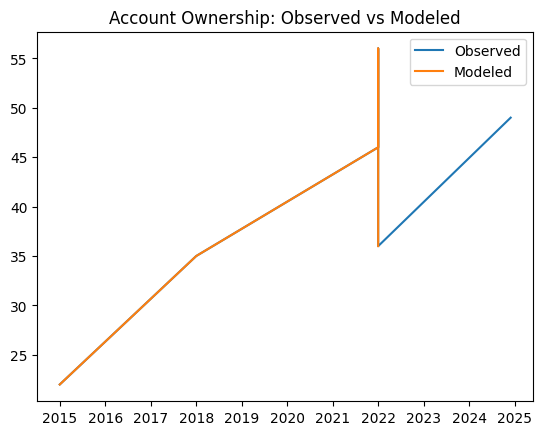

In [44]:
##
# validate and reality
import matplotlib.pyplot as plt

plt.figure()
plt.plot(acc_series.index, acc_series.values, label="Observed")
plt.plot(acc_pred.index, acc_pred.values, label="Modeled")
plt.legend()
plt.title("Account Ownership: Observed vs Modeled")
plt.show()


In [45]:
##
# Refine Impact Estimates
##

# --- Make sure columns are flat
impact_full.columns = [c if not isinstance(c, tuple) else c[0] for c in impact_full.columns]

# --- Confidence weighting
impact_full["confidence_weight"] = impact_full["confidence_impact"].map({
    "high": 1.0,
    "medium": 0.7,
    "low": 0.4
})

# --- Ensure impact magnitude is numeric
impact_full["impact_magnitude_impact"] = pd.to_numeric(
    impact_full["impact_magnitude_impact"], errors="coerce"
)

# --- Adjusted magnitude
impact_full["adjusted_magnitude"] = (
    impact_full["impact_magnitude_impact"] * impact_full["confidence_weight"]
)

# --- Build refined matrix
matrix_refined = impact_full.pivot_table(
    index="indicator_event",
    columns="related_indicator_impact",
    values="adjusted_magnitude",
    aggfunc="mean"
).fillna(0)

print(matrix_refined)

Empty DataFrame
Columns: []
Index: []


In [46]:
print("Matrix shape:", matrix.shape)
print(matrix.head())

matrix_clean = matrix.dropna(how="all").dropna(axis=1, how="all")
print("Cleaned Matrix shape:", matrix_clean.shape)

print("Clean matrix shape:", matrix_clean.shape)
print(matrix_clean.head())

Matrix shape: (0, 0)
Empty DataFrame
Columns: []
Index: []
Cleaned Matrix shape: (0, 0)
Clean matrix shape: (0, 0)
Empty DataFrame
Columns: []
Index: []


In [47]:
##
# Heatmap Visualization
##

if matrix_clean.shape[0] > 0 and matrix_clean.shape[1] > 0:
    plt.figure(figsize=(10,6))
    sns.heatmap(matrix_clean, annot=True, cmap="coolwarm")
    plt.title("Event → Indicator Impact Matrix")
    plt.tight_layout()
    plt.show()
else:
    print("Heatmap skipped: matrix has no data to plot.")


Heatmap skipped: matrix has no data to plot.


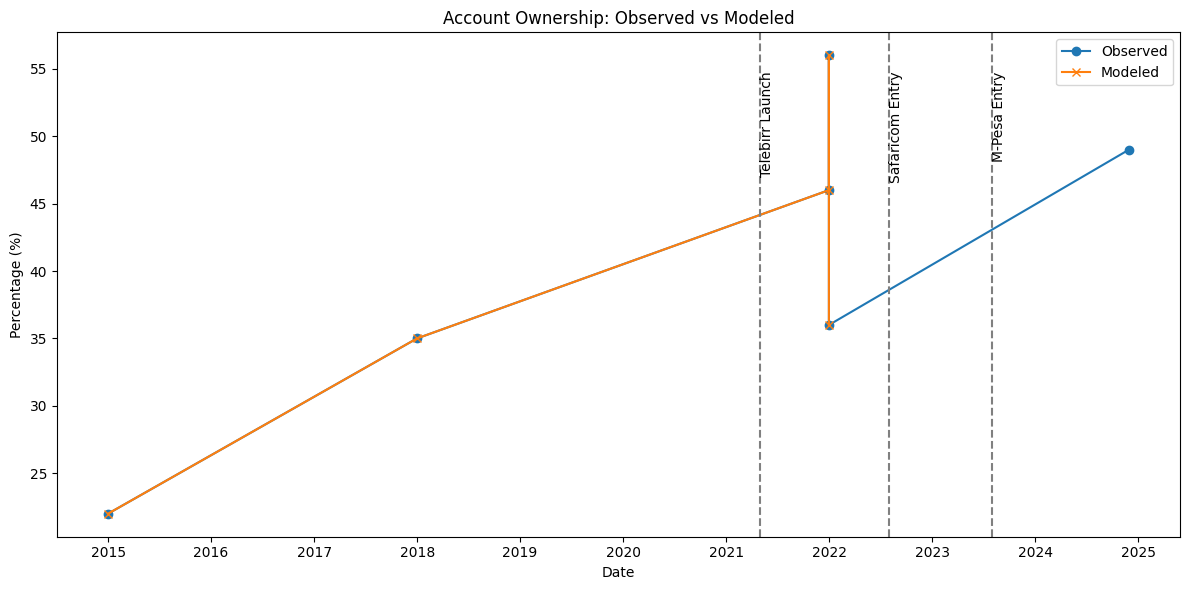

In [48]:
# Example for Account Ownership (ACC_OWNERSHIP)
plt.figure(figsize=(12,6))
plt.plot(acc_series.index, acc_series.values, label="Observed", marker='o')
plt.plot(acc_pred.index, acc_pred.values, label="Modeled", marker='x')

# Annotate key events
key_events = {
    "Telebirr Launch": "2021-05-01",
    "Safaricom Entry": "2022-08-01",
    "M-Pesa Entry": "2023-08-01"
}

for label, date in key_events.items():
    plt.axvline(pd.to_datetime(date), color='gray', linestyle='--')
    plt.text(pd.to_datetime(date), plt.ylim()[1]*0.95, label, rotation=90, verticalalignment='top')

plt.title("Account Ownership: Observed vs Modeled")
plt.xlabel("Date")
plt.ylabel("Percentage (%)")
plt.legend()
plt.tight_layout()
plt.show()


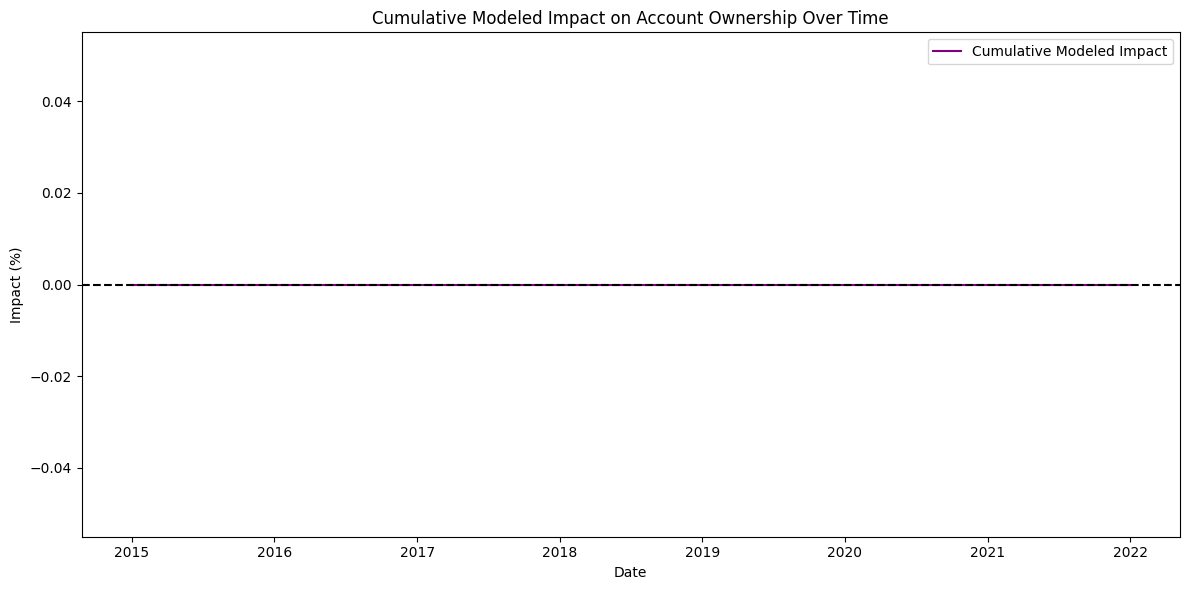

In [ ]:
# Example: cumulative modeled effect on ACC_OWNERSHIP
cumulative_impact = acc_pred - acc_series

plt.figure(figsize=(12,6))
plt.plot(cumulative_impact.index, cumulative_impact.values, label="Cumulative Modeled Impact", color='purple')
plt.title("Cumulative Modeled Impact on Account Ownership Over Time")
plt.xlabel("Date")
plt.ylabel("Impact (%)")
plt.axhline(0, color='black', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

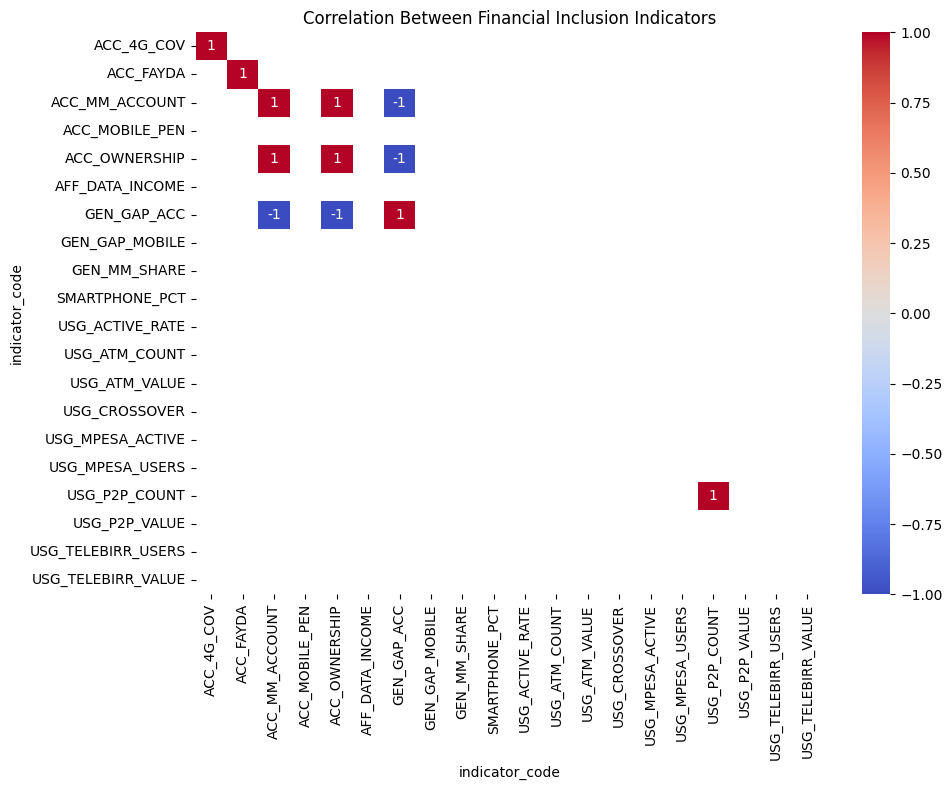

In [51]:
# Pivot to wide format by indicator and observation date
obs_wide = observations.pivot_table(
    index='observation_date',
    columns='indicator_code',
    values='value_numeric'
)

plt.figure(figsize=(10,8))
sns.heatmap(obs_wide.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Between Financial Inclusion Indicators")
plt.tight_layout()
plt.show()
